In [1]:
import math
import gym 
import random 
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 

from matplotlib.pyplot import imshow, show
from IPython.display import clear_output

In [2]:
class RnnNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, hidden_dim):
        super(RnnNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.fc1 = nn.Linear(observation_dim, hidden_dim)
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, obs, hidden_state):
        x = F.relu(self.fc1(obs))
        hidden = hidden_state.reshape(-1, self.hidden_dim)
        hidden = self.gru(x, hidden)
        out = self.fc2(hidden)
        return out, hidden

class ReplayBufferRnn():
    def __init__(self, buffer_size, episode_maxstep, observation_dim):
        self.buffer_size = buffer_size
        self.episode_maxstep = episode_maxstep
        self.observation_dim = observation_dim
        self.current_idx = 0
        self.current_size = 0
  
        self.memory = {"o": np.empty([self.buffer_size, self.episode_maxstep, self.observation_dim]),
                       "u": np.empty([self.buffer_size, self.episode_maxstep, 1]),
                       "r": np.empty([self.buffer_size, self.episode_maxstep, 1]),
                       "o_next": np.empty([self.buffer_size, self.episode_maxstep, self.observation_dim]),
                       "padded": np.empty([self.buffer_size, self.episode_maxstep, 1]),
                       "terminate": np.empty([self.buffer_size, self.episode_maxstep, 1])}

    def add(self, new_eps):
        self.memory['o'][self.current_idx] = new_eps['o']
        self.memory['u'][self.current_idx] = new_eps['u']
        self.memory['r'][self.current_idx] = new_eps['r']
        self.memory['o_next'][self.current_idx] = new_eps['o_next']
        self.memory['padded'][self.current_idx] = new_eps['padded']
        self.memory['terminate'][self.current_idx] = new_eps['terminate']

        self.current_size = min(self.current_size + 1, self.buffer_size)
        self.current_idx = 0 if self.current_idx == self.buffer_size - 1 else self.current_idx + 1

    def sample(self, minibatch_size):
        temp_buffer = {}
        if self.current_size < minibatch_size:
            return None
        
        idx = random.sample(range(self.current_size), minibatch_size)
        for key in self.memory.keys():
            temp_buffer[key] = self.memory[key][idx]

        return temp_buffer

class DRQNAgent(object):
    def __init__(self, model, target_model, memory, gamma, batch_size, e, e_min, e_decay, update_freq, lr = 1e-3):
        self.model = model
        self.target_model = target_model

        self.hidden_state = None
        self.target_hidden_state = None

        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.memory = memory

        self.e = e
        self.e_min = e_min
        self.e_decay = e_decay
        self.batch_size = batch_size

        self.train_step = 0
        self.update_freq = update_freq

    def init_hidden_state(self, batch_size):
        self.hidden_state = torch.zeros((batch_size, 1, self.model.hidden_dim))
        self.target_hidden_state = torch.zeros((batch_size, 1, self.target_model.hidden_dim))

    def act(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        q_value, self.hidden_state = self.model(obs, self.hidden_state)
        if np.random.rand() <= self.e:
            return random.randrange(len(q_value[0]))
        else:
            return torch.argmax(q_value[0]).item()

    def get_inputs(self, batch, transition_idx):
        obs, obs_next = batch['o'][:, transition_idx, :], batch['o_next'][:, transition_idx, :]
        inputs = torch.tensor(obs, dtype=torch.float32)
        inputs_next = torch.tensor(obs_next, dtype=torch.float32)
        return inputs, inputs_next

    def get_q_targetq_frombatch(self, batch, batch_max_step):
        q_preds, q_targets = [], []
        for timestep in range(batch_max_step):
            inputs, inputs_next = self.get_inputs(batch, timestep)
            q_pred, self.hidden_state = self.model(inputs, self.hidden_state)
            q_target, self.target_hidden_state = self.target_model(inputs_next, self.target_hidden_state)
            q_preds.append(q_pred)
            q_targets.append(q_target)
        q_preds = torch.stack(q_preds, dim=1)
        q_targets = torch.stack(q_targets, dim=1)
        return q_preds, q_targets

    def _get_batch_max_step(self, batch):
        terminated = batch['terminate']
        episode_num = terminated.shape[0]
        max_episode_len = 0
        for episode_idx in range(episode_num):
            for transition_idx in range(self.memory.episode_maxstep):
                if terminated[episode_idx, transition_idx] == 1:
                    if transition_idx + 1 >= max_episode_len:
                        max_episode_len = transition_idx + 1
                    break
        if max_episode_len == 0:
            max_episode_len = self.memory.episode_maxstep
        return max_episode_len

    def learn(self):
        batch = self.memory.sample(self.batch_size)

        if batch is not None:
            batch_max_step = self._get_batch_max_step(batch)

            for key in batch.keys():
                batch[key] = batch[key][:, :batch_max_step]
            self.e = max(self.e_min, self.e * self.e_decay)
            self.init_hidden_state(self.batch_size)

            for key in batch.keys():
                if key == 'u':
                    batch[key] = torch.tensor(batch[key], dtype=torch.long)
                else:
                    batch[key] = torch.tensor(batch[key], dtype=torch.float32)

            u, r, terminal = batch['u'], batch['r'], batch['terminate']
           
            mask = 1 - batch["padded"].float()

            q_preds, q_targets = self.get_q_targetq_frombatch(batch, batch_max_step)

            q_preds = (torch.gather(q_preds, dim=2, index=u)).squeeze(1)
            q_targets = (q_targets.max(dim=2)[0]).unsqueeze(2)

            targets = r + self.gamma * q_targets * (1 - terminal)
            td_error = (q_preds - targets.detach())

            masked_td_error = mask * td_error
            loss = (masked_td_error ** 2).sum() / mask.sum()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.train_step += 1
            if self.train_step % self.update_freq:
                self.target_model.load_state_dict(self.model.state_dict())

In [3]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

class Rollout(object):
    def __init__(self, env, agent, observation_shape):
        self.env = env
        self.agent = agent
        self.observation_shape = observation_shape

    def generate_episode(self):
        observation = self.env.reset()[::2]
        o, o_next, u, r, terminate, padded = [], [], [], [], [], []
        terminal = False
        step = 0
        self.agent.init_hidden_state(1)

        while not terminal and step < self.agent.memory.episode_maxstep:
            action = self.agent.act(observation)
            next_observation, reward, terminal, _ = self.env.step(action)
            next_observation = next_observation[::2]
            o.append(observation)
            o_next.append(next_observation)
            observation = next_observation
            u.append([action])
            r.append([reward])
            terminate.append([1.0 if terminal else 0.0])
            padded.append([0.0])
            step += 1

        for i in range(step, self.agent.memory.episode_maxstep):
            o.append(np.zeros((self.observation_shape)))
            u.append(np.zeros((1)))
            r.append([0.0])
            o_next.append(np.zeros((self.observation_shape)))
            padded.append([1.0])
            terminate.append([1.0])

        episode = dict(o=o.copy(),
                       u=u.copy(),
                       r=r.copy(),
                       o_next=o_next.copy(),
                       padded=padded.copy(),
                       terminate=terminate.copy()
                       )

        #print("score :{}".format(step))
        return episode, step

def main():
    observation_dim = 2
    hidden_dim = 32
    action_dim = 2

    drqn_net = RnnNetwork(observation_dim, action_dim, hidden_dim)
    drqn_target_net = RnnNetwork(observation_dim, action_dim, hidden_dim)
    drqn_target_net.load_state_dict(drqn_net.state_dict())

    buffer_size = 10000
    episode_maxstep = 500
    replay_buffer = ReplayBufferRnn(buffer_size, episode_maxstep, observation_dim)

    gamma = 0.9
    minibatch_size = 2
    e = 1.0
    e_min = 0.01
    e_decay = 0.99
    update_freq = 10
    drqn_agent = DRQNAgent(drqn_net, drqn_target_net, replay_buffer, gamma, minibatch_size, e, e_min, e_decay,
                           update_freq)

    env = gym.make('CartPole-v1')
    rollout = Rollout(env, drqn_agent, observation_dim)

    max_train_episodes = 10000
    current_eps = 0
    collect_n_episode = 1
    scores = deque(maxlen=100)
    moving_average = []
    while current_eps <= max_train_episodes:
        episode, step = rollout.generate_episode()
        scores.append(step)
        if current_eps % 100 == 0:
            print("Episode {} Average Reward {} Best Reward {} Epsilon {:.2}".format(current_eps, np.mean(scores), np.max(scores), drqn_agent.e))
        #print("episode {}/{}".format(current_episode, max_train_episodes))
        #print("epsilon {:.2}".format(drqn_agent.e))
        moving_average.append(np.mean(scores))
        drqn_agent.memory.add(episode)
        drqn_agent.learn()
        current_eps += 1

    plt.plot(moving_average)
    plt.title('DRQN Solve Cartpole')
    plt.ylabel('Score')
    plt.xlabel('Episodes')
    plt.show()

/Users/regina/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/regina/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/var/folders/bk/km4jr97x4t3386lc8kvtzh300000gn/T/ipykernel_45188/834586320.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(obs, dtype=torch.float32)
/var/folders/bk/km4jr97x4t3386lc8kvtzh300000gn/T/ipykernel_45188/834586320.py:89: UserWarning: To copy construct f

Episode 0 Average Reward 48.0 Best Reward 48 Epsilon 1.0
Episode 100 Average Reward 16.84 Best Reward 69 Epsilon 0.37
Episode 200 Average Reward 11.44 Best Reward 20 Epsilon 0.14
Episode 300 Average Reward 12.51 Best Reward 24 Epsilon 0.05
Episode 400 Average Reward 10.85 Best Reward 16 Epsilon 0.018
Episode 500 Average Reward 10.93 Best Reward 15 Epsilon 0.01
Episode 600 Average Reward 10.16 Best Reward 15 Epsilon 0.01
Episode 700 Average Reward 11.14 Best Reward 17 Epsilon 0.01
Episode 800 Average Reward 17.52 Best Reward 57 Epsilon 0.01
Episode 900 Average Reward 24.68 Best Reward 51 Epsilon 0.01
Episode 1000 Average Reward 22.59 Best Reward 50 Epsilon 0.01
Episode 1100 Average Reward 24.31 Best Reward 50 Epsilon 0.01
Episode 1200 Average Reward 22.19 Best Reward 49 Epsilon 0.01
Episode 1300 Average Reward 18.86 Best Reward 45 Epsilon 0.01
Episode 1400 Average Reward 15.65 Best Reward 49 Epsilon 0.01
Episode 1500 Average Reward 26.37 Best Reward 58 Epsilon 0.01
Episode 1600 Average 

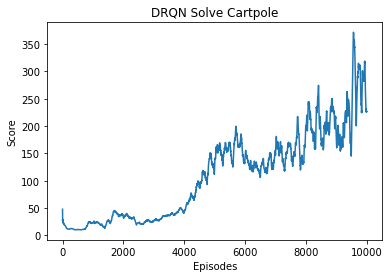

In [4]:
main()

In [5]:
import sys
from typing import Dict, List, Tuple

import gym
import collections
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter


# Q_network
class Q_net(nn.Module):
    def __init__(self, state_space=None,
                 action_space=None):
        super(Q_net, self).__init__()

        # space size check
        assert state_space is not None, "None state_space input: state_space should be selected."
        assert action_space is not None, "None action_space input: action_space should be selected."

        self.hidden_space = 64
        self.state_space = state_space
        self.action_space = action_space

        self.Linear1 = nn.Linear(self.state_space, self.hidden_space)
        self.lstm    = nn.LSTM(self.hidden_space,self.hidden_space, batch_first=True)
        self.Linear2 = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        x = F.relu(self.Linear1(x))
        x, (new_h, new_c) = self.lstm(x,(h,c))
        x = self.Linear2(x)
        return x, new_h, new_c

    def sample_action(self, obs, h,c, epsilon):
        output = self.forward(obs, h,c)

        if random.random() < epsilon:
            return random.randint(0,1), output[1], output[2]
        else:
            return output[0].argmax().item(), output[1] , output[2]
    
    def init_hidden_state(self, batch_size, training=None):

        assert training is not None, "training step parameter should be dtermined"

        if training is True:
            return torch.zeros([1, batch_size, self.hidden_space]), torch.zeros([1, batch_size, self.hidden_space])
        else:
            return torch.zeros([1, 1, self.hidden_space]), torch.zeros([1, 1, self.hidden_space])

class EpisodeMemory():
    """Episode memory for recurrent agent"""

    def __init__(self, random_update=False, 
                       max_epi_num=100, max_epi_len=500,
                       batch_size=1,
                       lookup_step=None):
        self.random_update = random_update # if False, sequential update
        self.max_epi_num = max_epi_num
        self.max_epi_len = max_epi_len
        self.batch_size = batch_size
        self.lookup_step = lookup_step

        if (random_update is False) and (self.batch_size > 1):
            sys.exit('It is recommend to use 1 batch for sequential update, if you want, erase this code block and modify code')

        self.memory = collections.deque(maxlen=self.max_epi_num)

    def put(self, episode):
        self.memory.append(episode)

    def sample(self):
        sampled_buffer = []

        ##################### RANDOM UPDATE ############################
        if self.random_update: # Random upodate
            sampled_episodes = random.sample(self.memory, self.batch_size)
            
            check_flag = True # check if every sample data to train is larger than batch size
            min_step = self.max_epi_len

            for episode in sampled_episodes:
                min_step = min(min_step, len(episode)) # get minimum step from sampled episodes

            for episode in sampled_episodes:
                if min_step > self.lookup_step: # sample buffer with lookup_step size
                    idx = np.random.randint(0, len(episode)-self.lookup_step+1)
                    sample = episode.sample(random_update=self.random_update, lookup_step=self.lookup_step, idx=idx)
                    sampled_buffer.append(sample)
                else:
                    idx = np.random.randint(0, len(episode)-min_step+1) # sample buffer with minstep size
                    sample = episode.sample(random_update=self.random_update, lookup_step=min_step, idx=idx)
                    sampled_buffer.append(sample)

        ##################### SEQUENTIAL UPDATE ############################           
        else: # Sequential update
            idx = np.random.randint(0, len(self.memory))
            sampled_buffer.append(self.memory[idx].sample(random_update=self.random_update))

        return sampled_buffer, len(sampled_buffer[0]['obs']) # buffers, sequence_length

    def __len__(self):
        return len(self.memory)


class EpisodeBuffer:
    """A simple numpy replay buffer."""

    def __init__(self):
        self.obs = []
        self.action = []
        self.reward = []
        self.next_obs = []
        self.done = []

    def put(self, transition):
        self.obs.append(transition[0])
        self.action.append(transition[1])
        self.reward.append(transition[2])
        self.next_obs.append(transition[3])
        self.done.append(transition[4])

    def sample(self, random_update=False, lookup_step=None, idx=None) -> Dict[str, np.ndarray]:
        obs = np.array(self.obs)
        action = np.array(self.action)
        reward = np.array(self.reward)
        next_obs = np.array(self.next_obs)
        done = np.array(self.done)

        if random_update is True:
            obs = obs[idx:idx+lookup_step]
            action = action[idx:idx+lookup_step]
            reward = reward[idx:idx+lookup_step]
            next_obs = next_obs[idx:idx+lookup_step]
            done = done[idx:idx+lookup_step]

        return dict(obs=obs,
                    acts=action,
                    rews=reward,
                    next_obs=next_obs,
                    done=done)

    def __len__(self) -> int:
        return len(self.obs)


def train(q_net=None, target_q_net=None, episode_memory=None,
          device=None, 
          optimizer = None,
          batch_size=1,
          learning_rate=1e-3,
          gamma=0.99):

    assert device is not None, "None Device input: device should be selected."

    # Get batch from replay buffer
    samples, seq_len = episode_memory.sample()

    observations = []
    actions = []
    rewards = []
    next_observations = []
    dones = []

    for i in range(batch_size):
        observations.append(samples[i]["obs"])
        actions.append(samples[i]["acts"])
        rewards.append(samples[i]["rews"])
        next_observations.append(samples[i]["next_obs"])
        dones.append(samples[i]["done"])

    observations = np.array(observations)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_observations = np.array(next_observations)
    dones = np.array(dones)

    observations = torch.FloatTensor(observations.reshape(batch_size,seq_len,-1)).to(device)
    actions = torch.LongTensor(actions.reshape(batch_size,seq_len,-1)).to(device)
    rewards = torch.FloatTensor(rewards.reshape(batch_size,seq_len,-1)).to(device)
    next_observations = torch.FloatTensor(next_observations.reshape(batch_size,seq_len,-1)).to(device)
    dones = torch.FloatTensor(dones.reshape(batch_size,seq_len,-1)).to(device)

    h_target, c_target = target_q_net.init_hidden_state(batch_size=batch_size, training=True)

    q_target, _, _ = target_q_net(next_observations, h_target.to(device), c_target.to(device))

    q_target_max = q_target.max(2)[0].view(batch_size,seq_len,-1).detach()
    targets = rewards + gamma*q_target_max*dones


    h, c = q_net.init_hidden_state(batch_size=batch_size, training=True)
    q_out, _, _ = q_net(observations, h.to(device), c.to(device))
    q_a = q_out.gather(2, actions)

    # Multiply Importance Sampling weights to loss        
    loss = F.smooth_l1_loss(q_a, targets)
    
    # Update Network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

if __name__ == "__main__":

    # Env parameters
    model_name = "DRQN_POMDP_Random"
    env_name = "CartPole-v1"
    seed = 1
    exp_num = 'SEED'+'_'+str(seed)

    # Set gym environment
    env = gym.make(env_name)

    device = torch.device("cpu")

    # Set the seed
    np.random.seed(seed)

    # default `log_dir` is "runs" - we'll be more specific here

    # Set parameters
    batch_size = 8
    learning_rate = 1e-3
    buffer_len = int(100000)
    min_epi_num = 20 # Start moment to train the Q network
    episodes = 1000
    print_per_iter = 100
    target_update_period = 4
    eps_start = 0.1
    eps_end = 0.001
    eps_decay = 0.995
    tau = 1e-2
    max_step = 2000

    # DRQN param
    random_update = True# If you want to do random update instead of sequential update
    lookup_step = 20 # If you want to do random update instead of sequential update
    max_epi_len = 100 
    max_epi_step = max_step

    

    # Create Q functions
    Q = Q_net(state_space=env.observation_space.shape[0]-2, 
              action_space=env.action_space.n).to(device)
    Q_target = Q_net(state_space=env.observation_space.shape[0]-2, 
                     action_space=env.action_space.n).to(device)

    Q_target.load_state_dict(Q.state_dict())

    # Set optimizer
    score = 0
    score_sum = 0
    optimizer = optim.Adam(Q.parameters(), lr=learning_rate)

    epsilon = eps_start
    
    episode_memory = EpisodeMemory(random_update=random_update, 
                                   max_epi_num=100, max_epi_len=600, 
                                   batch_size=batch_size, 
                                   lookup_step=lookup_step)

    # Train
    for i in range(episodes):
        s = env.reset()
        obs = s[::2] # Use only Position of Cart and Pole
        done = False
        
        episode_record = EpisodeBuffer()
        h, c = Q.init_hidden_state(batch_size=batch_size, training=False)

        for t in range(max_step):

            # Get action
            a, h, c = Q.sample_action(torch.from_numpy(obs).float().to(device).unsqueeze(0).unsqueeze(0), 
                                              h.to(device), c.to(device),
                                              epsilon)

            # Do action
            s_prime, r, done, _ = env.step(a)
            obs_prime = s_prime[::2]

            # make data
            done_mask = 0.0 if done else 1.0

            episode_record.put([obs, a, r/100.0, obs_prime, done_mask])

            obs = obs_prime
            
            score += r
            score_sum += r

            if len(episode_memory) >= min_epi_num:
                train(Q, Q_target, episode_memory, device, 
                        optimizer=optimizer,
                        batch_size=batch_size,
                        learning_rate=learning_rate)

                if (t+1) % target_update_period == 0:
                    # Q_target.load_state_dict(Q.state_dict()) <- navie update
                    for target_param, local_param in zip(Q_target.parameters(), Q.parameters()): # <- soft update
                            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
                
            if done:
                break
        
        episode_memory.put(episode_record)
        
        epsilon = max(eps_end, epsilon * eps_decay) #Linear annealing

        if i % print_per_iter == 0 and i!=0:
            print("Episode: {}, Average Reward: {:.1f} Epsilon: {:.2}".format(i, score_sum/print_per_iter, epsilon))
            score_sum=0.0
            save_model(Q, model_name+"_"+exp_num+'.pth')

        # Log the reward
        writer.add_scalar('Rewards per episodes', score, i)
        score = 0
        
    writer.close()
    env.close()

NameError: name 'writer' is not defined